## 삼성전자 사업부문별(DS, IM, CE, 하만 등) 관련주들과의 상관관계 분석 + 매출비율에 따른 가중치

https://news.samsung.com/kr/%ec%82%bc%ec%84%b1%ec%a0%84%ec%9e%90-2020%eb%85%84-4%eb%b6%84%ea%b8%b0-%ec%8b%a4%ec%a0%81-%eb%b0%9c%ed%91%9c

삼성전자의 사업 부문별2017~2020년도 분기별 매출 비율은은 
DS와 IM이 비슷하고, CE가 절반정도 (하만은 생략)

작년 4분기 삼성전자 매출
CE(전자)     : 13조(영업이익 0.82조)
IM(스마트폰) : 22조(영업이익 2.42조)
DS(반도체)   : 27조(영업이익 5.63조)
하만(오디오) :  3조(영업이익 0.18조)

사업부문별 관련 주식들
DS : NDBA, AMD, 인텔...
IM : SKC(011790), 한솔케미칼(014680), 파인테크닉스 (106240), ..
CE : LG전자(066570), 신화인터텍(056700), 엘엠에스(073110)...

삼성전자의 각 사업 부문별 관련주를 찾아와 평균치를 내고, 영업매출 비율에 따라 가중치를 줘서 비교
가정 : 사업부문에 따른 매출비율이 어느정도 반영이되어 주가에 영향을 줄 것이다.
한계 : 관련 주식이 해당 사업에만 영향을 주진 않음..

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
conda install -c conda-forge scikit-plot

Note: you may need to restart the kernel to use updated packages.

Solving environment: ...working... done

# All requested packages already installed.



In [4]:
!pip install yfinance
!pip install investpy
!pip install pykrx
!pip install seaborn
!pip install workalendar
!pip install --upgrade finance-datareader

You should consider upgrading via the 'c:\users\song\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\song\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\song\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\song\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\song\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\song\anaconda3\python.exe -m pip install --upgrade pip' command.


In [5]:
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import datetime
import yfinance as yf # yahoo finance API    # pip install yfinance
import investpy # investing.com API          # pip install investpy
from pykrx import stock # krx API           # pip instasll pykrx
import talib as ta # 기술적 분석 (보조지표)
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [116]:
# 크롤링 start_date, end_date
start_date='2017-01-01'
#input('YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2018-01-01 : ')
end_date='2020-12-31'
#input('YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2020-10-13 : ')

In [117]:
# 데이터 수집기간 입력
# yahoo finance 양식, ex) yyyy-mm-dd
#start_date = '2018-01-01'
#end_date = '2020-10-13'

# investing.com 양식, ex) dd/mm/yyyy
start_date_ = start_date[8:] + '/' + start_date[5:7] + '/' + start_date[:4]
end_date_ = end_date[8:] + '/' + end_date[5:7] + '/' + end_date[:4]

# krx 양식 ex) yyyymmdd
start_date__ = start_date[0:4] + start_date[5:7] + start_date[8:10]
end_date__ = end_date[0:4] + end_date[5:7] + end_date[8:10]

In [118]:
# 달러/원
exchange_rate_usd_ = investpy.get_currency_cross_historical_data(currency_cross='USD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_usd_.columns = ['exchange_rate_usd_Open', 'exchange_rate_usd_High', 'exchange_rate_usd_Low', 'exchange_rate_usd_Close', 'exchange_rate_usd_Currency']
exchange_rate_usd_ = exchange_rate_usd_.drop(['exchange_rate_usd_Open','exchange_rate_usd_High','exchange_rate_usd_Low','exchange_rate_usd_Currency'], axis=1)

# S&P 500
snp_500_ = yf.download("^GSPC", start=start_date, end=end_date)
snp_500_.columns = ['snp_500_Open','snp_500_High','snp_500_Low','snp_500_Close','snp_500_Adj Close','snp_500_Volume']
snp_500_ = snp_500_.drop(['snp_500_Open','snp_500_High','snp_500_Low','snp_500_Adj Close','snp_500_Volume'], axis=1)

# NASDAQ
nasdaq_ = yf.download("^IXIC", start=start_date, end=end_date)
nasdaq_.columns = ['nasdaq_Open','nasdaq_High','nasdaq_Low','nasdaq_Close','nasdaq_Adj Close','nasdaq_Volume']
nasdaq_ = nasdaq_.drop(['nasdaq_Open','nasdaq_High','nasdaq_Low','nasdaq_Adj Close','nasdaq_Volume'], axis=1)

# 삼성 차트 데이터
sam_ = stock.get_market_ohlcv_by_date(start_date__, end_date__, "005930")
sam_.columns = ['Open','High','Low','Close','Volume']
model_samsung = sam_.copy()

# 3) MACD 이동평균수렴확산 (단기(EMA12)와 장기(EMA26) EMA로 모멘텀을 추정)
macd, macdsignal9, macdhist = ta.MACD(model_samsung.Close, fastperiod=12, slowperiod=26, signalperiod=9)
model_samsung['macd'] = macd
model_samsung['macdsignal9'] = macdsignal9
model_samsung['macdhist'] = macdhist

MSCI_KR = fdr.DataReader('156080', start_date,end_date) #MSCI KOREA
MSCI_KR = MSCI_KR.drop(['Open','High','Low', 'Change','Volume'], axis=1) 
MSCI_KR.columns = ['MSCI_KR']




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [119]:
model_samsung

,Open,High,Low,Close,Volume,macd,macdsignal9,macdhist
날짜,,,,,,,,
2017-01-02,35980,36240,35880,36100,93012,NaN,NaN,NaN
2017-01-03,36280,36620,36020,36480,147153,NaN,NaN,NaN
2017-01-04,36500,36520,36100,36160,159435,NaN,NaN,NaN
2017-01-05,36060,36060,35540,35560,219349,NaN,NaN,NaN
2017-01-06,36180,36440,36040,36200,177619,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-12-23,72400,74000,72300,73900,19411326,2298.761089,2589.838826,-291.077738
2020-12-24,74100,78800,74000,77800,32502870,2541.752223,2580.221506,-38.469283
2020-12-28,79000,80100,78200,78700,40085044,2774.958927,2619.168990,155.789937


In [120]:
# DS 반도체, 메모리 관련 주식들
# AMD
AMD = fdr.DataReader('AMD', start_date, end_date)
AMD = AMD.drop(['Open','High','Low', 'Change','Volume'], axis=1) 
AMD.columns = ['AMD']

#INTEL
INTEL = fdr.DataReader('INTC', start_date, end_date)
INTEL = INTEL.drop(['Open','High','Low', 'Change','Volume'], axis=1) 
INTEL.columns = ['INTC']

#엔비디아
NVDA = fdr.DataReader('NVDA', start_date, end_date)
NVDA = NVDA.drop(['Open','High','Low', 'Change','Volume'], axis=1) 
NVDA.columns = ['NVDA']

model_samsung['DS_AMD'] = AMD
model_samsung['DS_INTEL'] = INTEL
model_samsung['DS_NVDA'] = NVDA

In [121]:
# IM 휴대폰, 현재는 폴더폰 관련주
# SKC
df1 = stock.get_market_ohlcv_by_date(start_date__, end_date__, "011790")
df1 = df1.drop(['시가','고가','저가','거래량'],axis=1)
df1.columns = ['Close']
model_samsung['IM_SKC'] = df1

#  파인테크닉스(148150)
df2 = stock.get_market_ohlcv_by_date(start_date__, end_date__, "106240")
df2 = df2.drop(['시가','고가','저가','거래량'],axis=1)
df2.columns = ['Close']
model_samsung['IM_FINE'] = df2

#  한솔케미칼(014680)
df3 = stock.get_market_ohlcv_by_date(start_date__, end_date__, "014680")
df3 = df3.drop(['시가','고가','저가','거래량'],axis=1)
df3.columns = ['Close']
model_samsung['IM_SOL'] = df3


In [122]:
# CE 생활전자 관련주
#  LG전자(066570)
df6 = stock.get_market_ohlcv_by_date(start_date__, end_date__, "066570")
df6 = df6.drop(['시가','고가','저가','거래량'],axis=1)
df6.columns = ['Close']
model_samsung['CE_LG'] = df6

#  신화인터텍(056700)
df7 = stock.get_market_ohlcv_by_date(start_date__, end_date__, "056700")
df7 = df7.drop(['시가','고가','저가','거래량'],axis=1)
df7.columns = ['Close']
model_samsung['CE_SHINHWA'] = df7

#  엘엠에스(073110)
df8 = stock.get_market_ohlcv_by_date(start_date__, end_date__, "073110")
df8 = df8.drop(['시가','고가','저가','거래량'],axis=1)
df8.columns = ['Close']
model_samsung['CE_LMS'] = df8

In [123]:
model_samsung 
#model_samsung = pd.DataFrame()

,Open,High,Low,Close,Volume,macd,macdsignal9,macdhist,DS_AMD,DS_INTEL,DS_NVDA,IM_SKC,IM_FINE,IM_SOL,CE_LG,CE_SHINHWA,CE_LMS
날짜,,,,,,,,,,,,,,,,,
2017-01-02,35980,36240,35880,36100,93012,NaN,NaN,NaN,NaN,NaN,NaN,33600,3405,86700,51600,3825,8340
2017-01-03,36280,36620,36020,36480,147153,NaN,NaN,NaN,11.43,36.60,102.01,33900,3575,86400,54300,3835,8310
2017-01-04,36500,36520,36100,36160,159435,NaN,NaN,NaN,11.43,36.41,104.39,32600,3530,83200,53800,3785,8280
2017-01-05,36060,36060,35540,35560,219349,NaN,NaN,NaN,11.24,36.35,101.74,32550,3405,83100,53600,3720,8310
2017-01-06,36180,36440,36040,36200,177619,NaN,NaN,NaN,11.32,36.48,103.10,32500,3450,82800,52600,3630,8290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,72400,74000,72300,73900,19411326,2298.761089,2589.838826,-291.077738,91.55,46.57,520.37,90900,4000,175500,119500,3045,14400
2020-12-24,74100,78800,74000,77800,32502870,2541.752223,2580.221506,-38.469283,91.81,47.07,519.75,91600,3975,184000,112000,3160,13500
2020-12-28,79000,80100,78200,78700,40085044,2774.958927,2619.168990,155.789937,91.60,47.07,516.00,91700,4030,182500,124500,3110,13200


In [124]:
model_samsung['US'] = exchange_rate_usd_
model_samsung['SNP500'] = snp_500_
model_samsung['NASDAQ'] = nasdaq_
model_samsung['MSCI_KR'] = MSCI_KR

In [125]:
model_samsung = model_samsung.dropna() # 결측치가 있는 행 제거

In [126]:
model_samsung = model_samsung.drop(['Open','High','Low','Volume'],axis=1)

In [127]:
model_samsung

,Close,macd,macdsignal9,macdhist,DS_AMD,DS_INTEL,DS_NVDA,IM_SKC,IM_FINE,IM_SOL,CE_LG,CE_SHINHWA,CE_LMS,US,SNP500,NASDAQ,MSCI_KR
날짜,,,,,,,,,,,,,,,,,
2017-02-21,38940,367.981524,569.998712,-202.017188,14.00,36.52,111.07,33400,3000,78400,62100,4060,10100,1142.89,2365.379883,5865.950195,11626
2017-02-22,39300,412.522500,538.503469,-125.980969,14.28,36.07,110.76,32800,2925,79500,62900,3910,10150,1138.48,2362.820068,5860.629883,11611
2017-02-23,39180,433.145516,517.431878,-84.286363,14.32,36.18,100.49,32950,2925,79700,63100,3835,9750,1133.10,2363.810059,5835.509766,11665
2017-02-24,38220,367.785821,487.502667,-119.716846,14.12,36.53,101.46,32750,2885,77500,62700,3690,9570,1130.50,2367.340088,5845.310059,11504
2017-02-27,38060,299.623259,449.926785,-150.303527,15.20,36.51,104.41,32050,2860,76300,59000,3835,9760,1134.65,2369.750000,5861.899902,11442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,73900,2298.761089,2589.838826,-291.077738,91.55,46.57,520.37,90900,4000,175500,119500,3045,14400,1106.65,3690.010010,12771.110352,17875
2020-12-24,77800,2541.752223,2580.221506,-38.469283,91.81,47.07,519.75,91600,3975,184000,112000,3160,13500,1101.59,3703.060059,12804.730469,18260
2020-12-28,78700,2774.958927,2619.168990,155.789937,91.60,47.07,516.00,91700,4030,182500,124500,3110,13200,1095.60,3735.360107,12899.419922,18245


In [128]:
# 차트 비교분석을 위한 정규화
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
fitted = min_max_scaler.fit(model_samsung)
output = min_max_scaler.transform(model_samsung)
output = pd.DataFrame(output, columns=model_samsung.columns, index=list(model_samsung.index.values))
print(output.head())

               Close      macd  macdsignal9  macdhist    DS_AMD  DS_INTEL  \
2017-02-21  0.034214  0.591511     0.607806  0.522061  0.051033  0.090000   
2017-02-22  0.042480  0.598004     0.602296  0.562403  0.054230  0.076765   
2017-02-23  0.039724  0.601011     0.598610  0.584525  0.054687  0.080000   
2017-02-24  0.017681  0.591482     0.593374  0.565727  0.052403  0.090294   
2017-02-27  0.014007  0.581545     0.586800  0.549499  0.064733  0.089706   

             DS_NVDA    IM_SKC   IM_FINE    IM_SOL     CE_LG  CE_SHINHWA  \
2017-02-21  0.031992  0.077592  0.412946  0.101901  0.217391    0.510242   
2017-02-22  0.031356  0.068891  0.396205  0.110266  0.225980    0.482309   
2017-02-23  0.010267  0.071066  0.396205  0.111787  0.228127    0.468343   
2017-02-24  0.012259  0.068165  0.387277  0.095057  0.223833    0.441341   
2017-02-27  0.018317  0.058013  0.381696  0.085932  0.184112    0.468343   

              CE_LMS        US    SNP500    NASDAQ   MSCI_KR  
2017-02-21  0.214

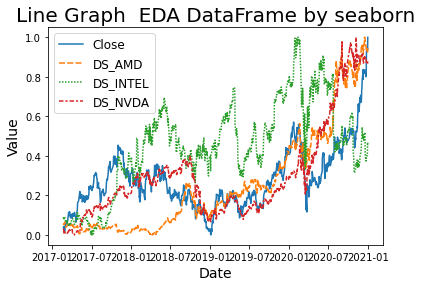

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt

## 삼성전자와 DS 사업부 관련주 비교
ax = sns.lineplot(data=output[['Close', 'DS_AMD', 'DS_INTEL', 'DS_NVDA']])

plt.title('Line Graph  EDA DataFrame by seaborn', fontsize=20)
plt.ylabel('Value', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.show()

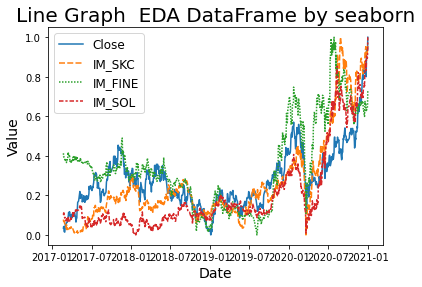

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

## 삼성전자와 IM 사업부 관련주 비교
ax = sns.lineplot(data=output[['Close', 'IM_SKC', 'IM_FINE', 'IM_SOL']])

plt.title('Line Graph  EDA DataFrame by seaborn', fontsize=20)
plt.ylabel('Value', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.show()

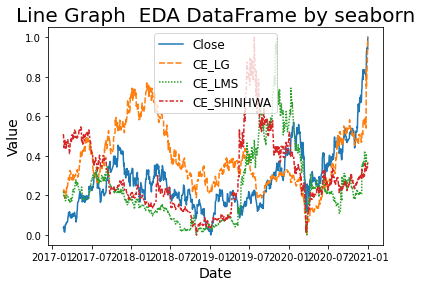

In [131]:
##삼성전자와 CE사업부 관련주 비교
ax = sns.lineplot(data=output[['Close', 'CE_LG','CE_LMS','CE_SHINHWA']])

plt.title('Line Graph  EDA DataFrame by seaborn', fontsize=20)
plt.ylabel('Value', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.show()

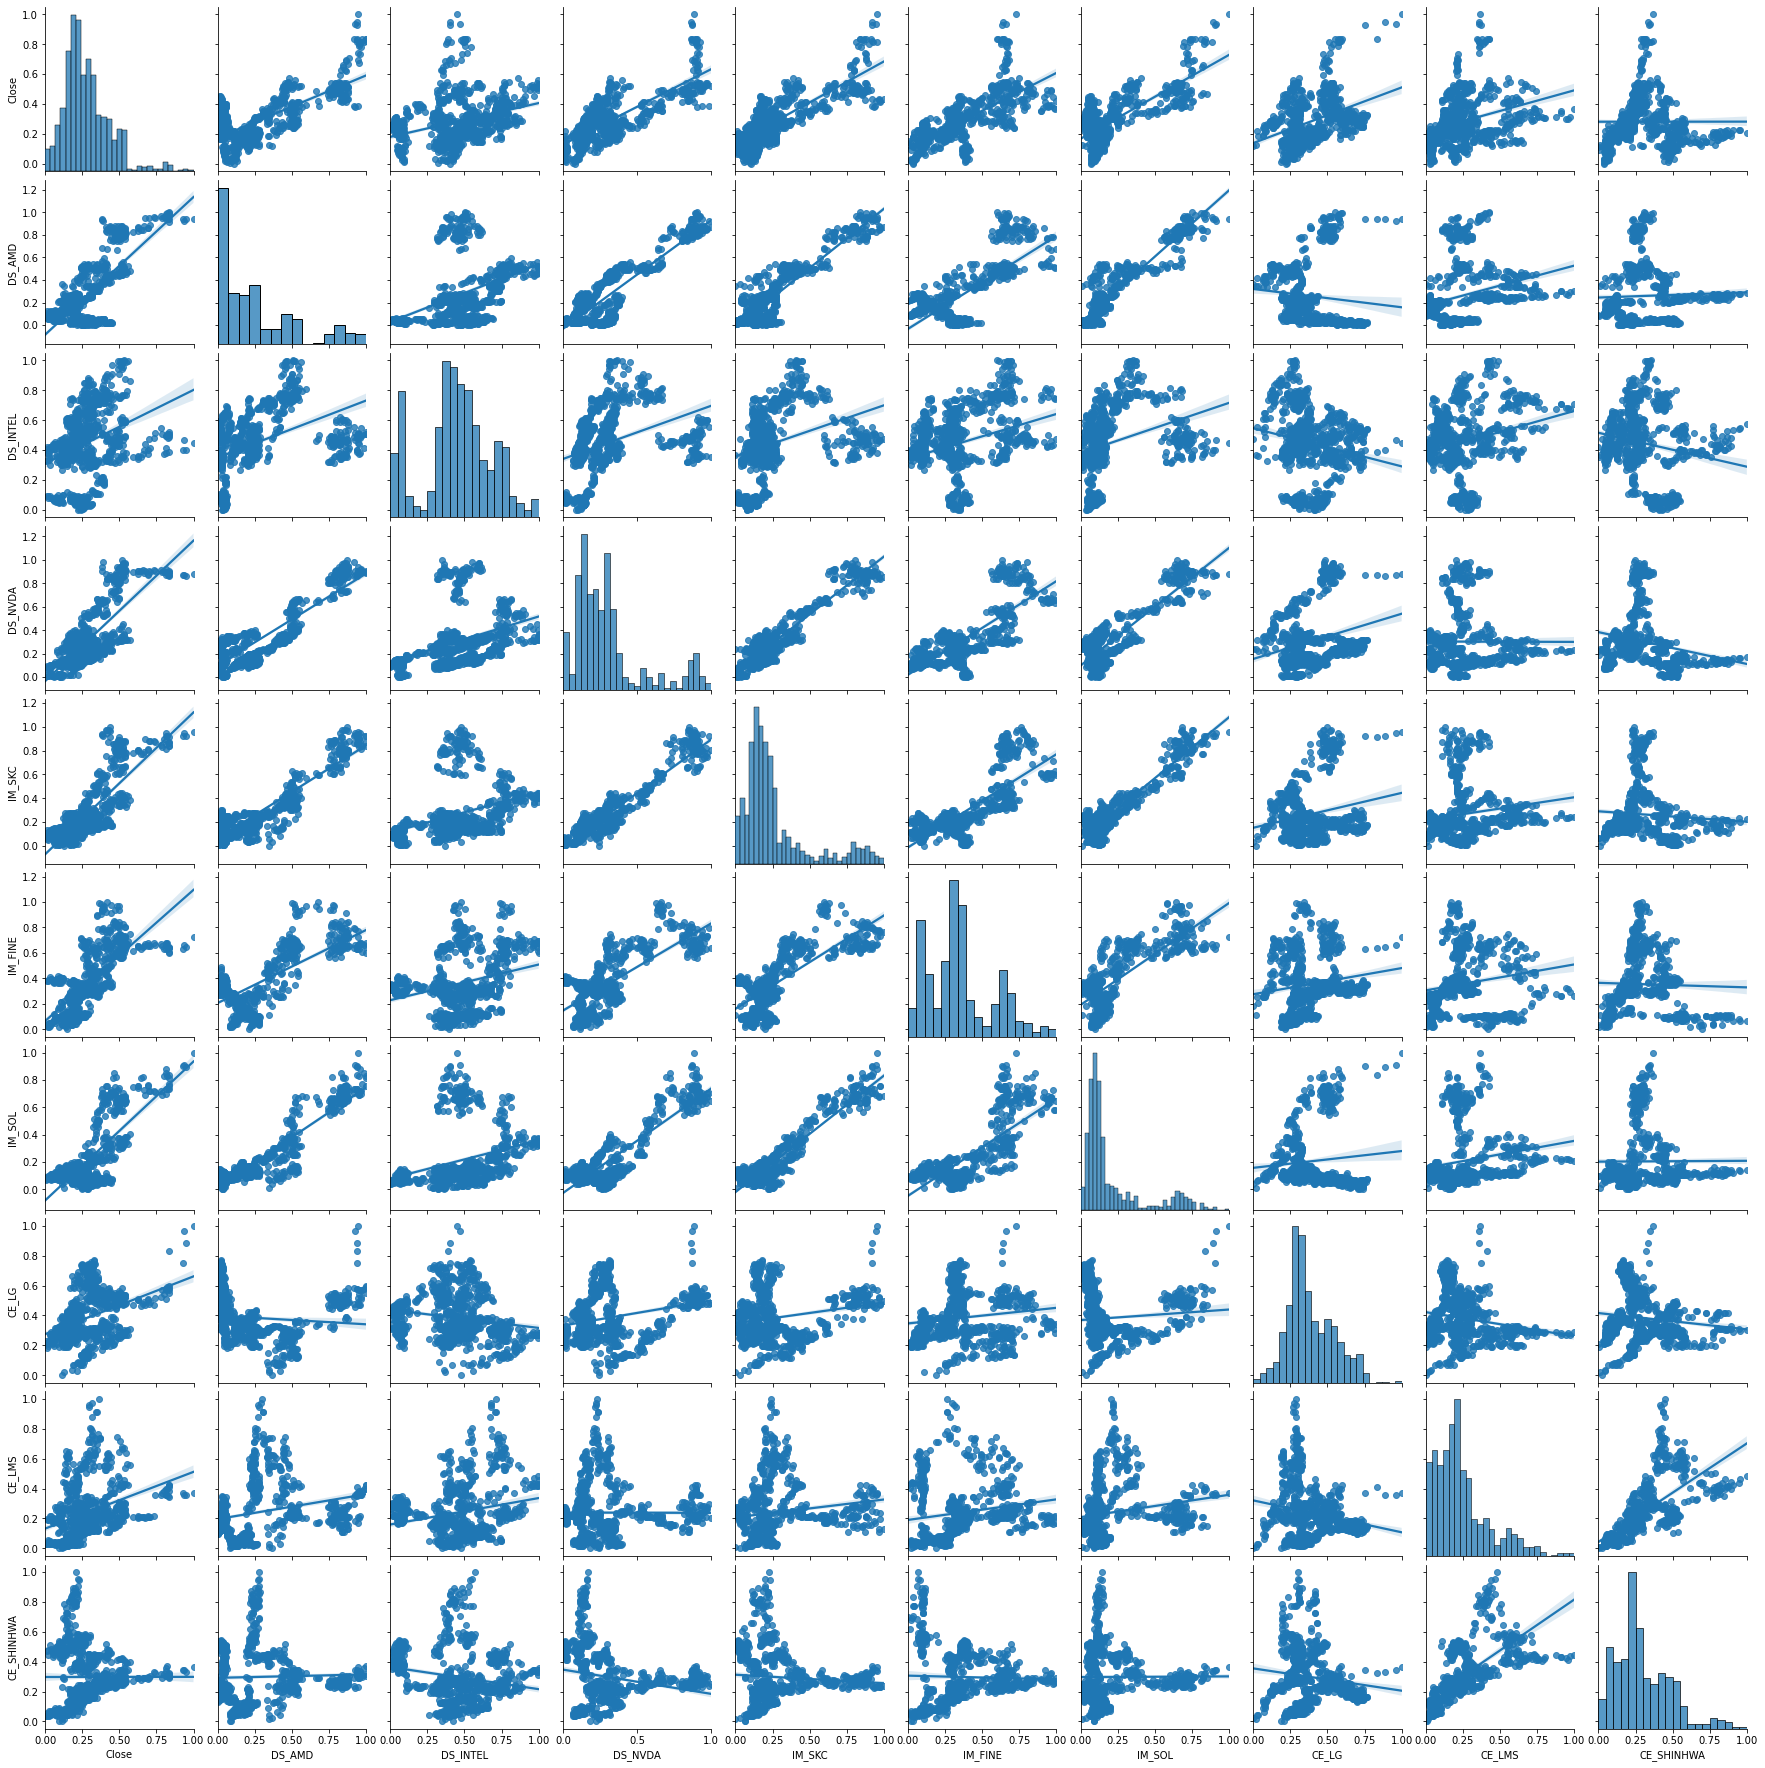

In [132]:
import seaborn as sns
sns.pairplot(output[['Close','DS_AMD', 'DS_INTEL', 'DS_NVDA', 'IM_SKC', 'IM_FINE','IM_SOL','CE_LG','CE_LMS','CE_SHINHWA']], kind='reg')

In [133]:
output.drop(['macdhist','macdsignal9', 'NASDAQ', 'MSCI_KR'],axis=1,inplace=True)

<AxesSubplot:>

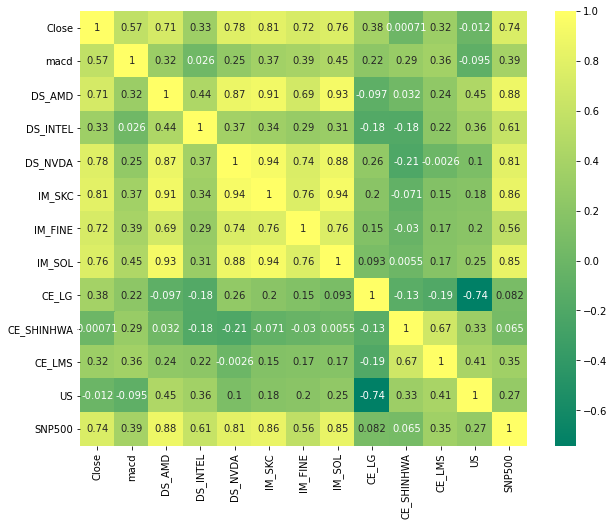

In [134]:
plt.figure(figsize=(10,8))
sns.heatmap(output.corr(), annot=True, cmap='summer')

In [135]:
output

,Close,macd,DS_AMD,DS_INTEL,DS_NVDA,IM_SKC,IM_FINE,IM_SOL,CE_LG,CE_SHINHWA,CE_LMS,US,SNP500
2017-02-21,0.034214,0.591511,0.051033,0.090000,0.031992,0.077592,0.412946,0.101901,0.217391,0.510242,0.214481,0.403329,0.085436
2017-02-22,0.042480,0.598004,0.054230,0.076765,0.031356,0.068891,0.396205,0.110266,0.225980,0.482309,0.216758,0.383106,0.083727
2017-02-23,0.039724,0.601011,0.054687,0.080000,0.010267,0.071066,0.396205,0.111787,0.228127,0.468343,0.198543,0.358433,0.084388
2017-02-24,0.017681,0.591482,0.052403,0.090294,0.012259,0.068165,0.387277,0.095057,0.223833,0.441341,0.190346,0.346510,0.086745
2017-02-27,0.014007,0.581545,0.064733,0.089706,0.018317,0.058013,0.381696,0.085932,0.184112,0.468343,0.198998,0.365542,0.088354
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0.836969,0.872996,0.936408,0.385588,0.872461,0.911530,0.636161,0.840304,0.833602,0.321229,0.410291,0.237137,0.969725
2020-12-24,0.926521,0.908421,0.939377,0.400294,0.871188,0.921682,0.630580,0.904943,0.753086,0.342644,0.369308,0.213932,0.978437
2020-12-28,0.947187,0.942420,0.936979,0.400294,0.863488,0.923133,0.642857,0.893536,0.887279,0.333333,0.355647,0.186462,1.000000
2020-12-29,0.938002,0.959795,0.925791,0.468529,0.867040,0.947788,0.660714,0.912548,0.962426,0.346369,0.360200,0.165230,0.994446


In [136]:
#각 사업부문별로 평균
output['DS'] = (output['DS_AMD'] + output['DS_INTEL'] + output['DS_NVDA']) / 3
output['IM'] = (output['IM_SKC'] + output['IM_FINE'] + output['IM_SOL']) / 3
output['CE'] = (output['CE_LG'] + output['CE_SHINHWA'] + output['CE_LMS']) / 3


In [137]:
output

,Close,macd,DS_AMD,DS_INTEL,DS_NVDA,IM_SKC,IM_FINE,IM_SOL,CE_LG,CE_SHINHWA,CE_LMS,US,SNP500,DS,IM,CE
2017-02-21,0.034214,0.591511,0.051033,0.090000,0.031992,0.077592,0.412946,0.101901,0.217391,0.510242,0.214481,0.403329,0.085436,0.057675,0.197480,0.314038
2017-02-22,0.042480,0.598004,0.054230,0.076765,0.031356,0.068891,0.396205,0.110266,0.225980,0.482309,0.216758,0.383106,0.083727,0.054117,0.191787,0.308349
2017-02-23,0.039724,0.601011,0.054687,0.080000,0.010267,0.071066,0.396205,0.111787,0.228127,0.468343,0.198543,0.358433,0.084388,0.048318,0.193019,0.298337
2017-02-24,0.017681,0.591482,0.052403,0.090294,0.012259,0.068165,0.387277,0.095057,0.223833,0.441341,0.190346,0.346510,0.086745,0.051652,0.183500,0.285173
2017-02-27,0.014007,0.581545,0.064733,0.089706,0.018317,0.058013,0.381696,0.085932,0.184112,0.468343,0.198998,0.365542,0.088354,0.057585,0.175214,0.283817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0.836969,0.872996,0.936408,0.385588,0.872461,0.911530,0.636161,0.840304,0.833602,0.321229,0.410291,0.237137,0.969725,0.731486,0.795998,0.521707
2020-12-24,0.926521,0.908421,0.939377,0.400294,0.871188,0.921682,0.630580,0.904943,0.753086,0.342644,0.369308,0.213932,0.978437,0.736953,0.819069,0.488346
2020-12-28,0.947187,0.942420,0.936979,0.400294,0.863488,0.923133,0.642857,0.893536,0.887279,0.333333,0.355647,0.186462,1.000000,0.733587,0.819842,0.525420
2020-12-29,0.938002,0.959795,0.925791,0.468529,0.867040,0.947788,0.660714,0.912548,0.962426,0.346369,0.360200,0.165230,0.994446,0.753787,0.840350,0.556332


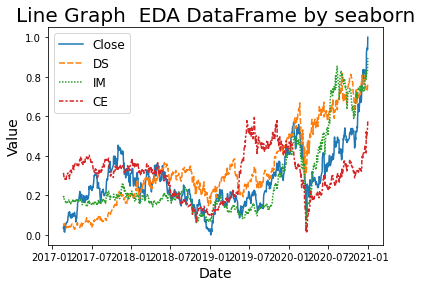

In [138]:
##삼성전자와 각 사업부 별 평균치 비교
ax = sns.lineplot(data=output[['Close', 'DS','IM','CE']])

plt.title('Line Graph  EDA DataFrame by seaborn', fontsize=20)
plt.ylabel('Value', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.show()

In [139]:
#각 사업부문별 영업 매출에 의한 비율 조정
# DS사업부와 IM사업부는 비슷하고, CE는 매출량이 반이므로 아래와같은 가중치를 준다.
output['TOTAL'] = (output['DS'] *2 + output['IM'] *2 + output['CE']) / 5

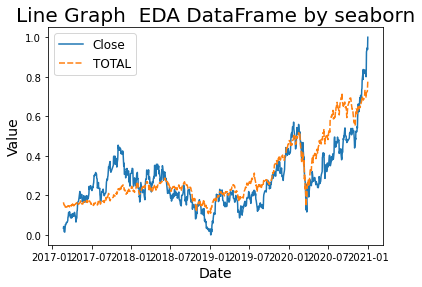

In [140]:
##삼성전자와 각 사업부 별 평균치 비교
ax = sns.lineplot(data=output[['Close', 'TOTAL']])

plt.title('Line Graph  EDA DataFrame by seaborn', fontsize=20)
plt.ylabel('Value', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.show()

In [141]:
output.drop(['DS_AMD','DS_INTEL','DS_NVDA','IM_SKC','IM_FINE','IM_SOL','CE_LG','CE_LMS','CE_SHINHWA'],axis=1,inplace=True)

In [142]:
output

,Close,macd,US,SNP500,DS,IM,CE,TOTAL
2017-02-21,0.034214,0.591511,0.403329,0.085436,0.057675,0.197480,0.314038,0.164870
2017-02-22,0.042480,0.598004,0.383106,0.083727,0.054117,0.191787,0.308349,0.160031
2017-02-23,0.039724,0.601011,0.358433,0.084388,0.048318,0.193019,0.298337,0.156202
2017-02-24,0.017681,0.591482,0.346510,0.086745,0.051652,0.183500,0.285173,0.151095
2017-02-27,0.014007,0.581545,0.365542,0.088354,0.057585,0.175214,0.283817,0.149883
...,...,...,...,...,...,...,...,...
2020-12-23,0.836969,0.872996,0.237137,0.969725,0.731486,0.795998,0.521707,0.715335
2020-12-24,0.926521,0.908421,0.213932,0.978437,0.736953,0.819069,0.488346,0.720078
2020-12-28,0.947187,0.942420,0.186462,1.000000,0.733587,0.819842,0.525420,0.726456
2020-12-29,0.938002,0.959795,0.165230,0.994446,0.753787,0.840350,0.556332,0.748921


<AxesSubplot:>

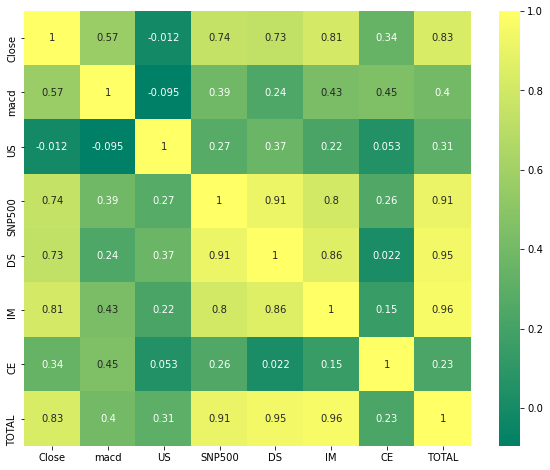

In [143]:
plt.figure(figsize=(10,8))
sns.heatmap(output.corr(), annot=True, cmap='summer')

In [ ]:
# TOTAL의 관련도를 높이기위해서는
# 각 사업부문별로 좀더 관련이 높은 주식을 더 많이 찾아 평균치를 내야 좀더 정확할 것같음..